In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import dataloader
import torch.nn as nn

https://arxiv.org/pdf/2010.11929

In [2]:
# PIL to tensor format
transformation_operation = transforms.Compose([transforms.ToTensor()])

In [3]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transformation_operation)
val_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transformation_operation)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.7MB/s]


In [4]:
num_classes = 10
batch_size = 64
num_channels = 1 # as MNIST black and white
img_size = 28 # MNIST image size is 28x28 pixels
patch_size = 7
num_patches = (img_size // patch_size) ** 2
embedding_dim = 64
attention_heads = 4
transfomer_blocks = 4
learning_rate = 0.001
epochs = 5
mlp_hidden_nodes = 128

2 x dimentional space with 128 hidden notes
try with 4 x

config embedding_dim to something different

visualize conv2d

In [5]:
# batches
train_loader = dataloader.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = dataloader.DataLoader(val_dataset, batch_size = batch_size, shuffle=True)

In [6]:
data_point, label = next(iter(train_loader))
print("Shape of data point:",data_point.shape)
patch_embed = nn.Conv2d(num_channels, embedding_dim, kernel_size=patch_size, stride=patch_size)
patch_embed_ouput = patch_embed(data_point)
print("Shape of patch embedding output:", patch_embed_ouput.shape)
patch_embed_output_flatten = patch_embed_ouput.flatten(2)
print("Flattened ouput:", patch_embed_output_flatten.shape)
print("Transposed Flattened ouput:", patch_embed_output_flatten.transpose(1,2).shape)

# combining everything we can write it as
print("Combined:", patch_embed(data_point).flatten(2).transpose(1,2).shape)

Shape of data point: torch.Size([64, 1, 28, 28])
Shape of patch embedding output: torch.Size([64, 64, 4, 4])
Flattened ouput: torch.Size([64, 64, 16])
Transposed Flattened ouput: torch.Size([64, 16, 64])
Combined: torch.Size([64, 16, 64])


In [7]:
# patch embedding
class PatchEmbedding(nn.Module):
  def __init__(self):
    super().__init__()
    self.patch_embed = nn.Conv2d(num_channels, embedding_dim, kernel_size=patch_size, stride=patch_size)

  def forward(self, x):
    x = self.patch_embed(x)
    x = x.flatten(2)
    x = x.transpose(1,2)
    return x
    # return patch_embed(data_point).flatten(2).transpose(1,2).shape

In [8]:
class TransformerEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_norm1 = nn.LayerNorm(embedding_dim)
    self.layer_norm2 = nn.LayerNorm(embedding_dim)
    self.attention = nn.MultiheadAttention(embedding_dim, attention_heads, batch_first=True)
    self.mlp = nn.Sequential(
        nn.Linear(embedding_dim, mlp_hidden_nodes),
        nn.GELU(),
        nn.Linear(mlp_hidden_nodes, embedding_dim)
    )

  def forward(self,x):
    residual1 = x
    x = self.layer_norm1(x)
    x = self.attention(x, x, x)[0]
    x = x + residual1

    residual2 = x
    x = self.layer_norm2(x)
    x = self.mlp(x)
    x = x + residual2

    return x

In [9]:
class MLP_head(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_norm = nn.LayerNorm(embedding_dim)
    self.mlp_head = nn.Linear(embedding_dim, num_classes)

  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp_head(x)

    return x

In [10]:
class VisionTransformer(nn.Module):
  def __init__(self):
    super().__init__()
    self.patch_embedding = PatchEmbedding()
    self.cls_token = nn.Parameter(torch.randn(1, 1, embedding_dim))
    self.position_embedding = nn.Parameter(torch.randn(1, 1 + num_patches, embedding_dim))
    self.transformer_blocks = nn.Sequential(*[TransformerEncoder() for _ in range(transfomer_blocks)])
    self.mlp_head = MLP_head()

  def forward(self, x):
    x = self.patch_embedding(x)
    B = x.size(0) # to solve dimentionality issues for batches of less than 64
    class_tokens = self.cls_token.expand(B, -1, -1)
    x = torch.cat((class_tokens, x), dim=1)
    x = x + self.position_embedding
    x = self.transformer_blocks(x)
    x = x[:, 0]
    x = self.mlp_head(x)

    return x # 10 dimentional


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
model = VisionTransformer().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [12]:
for epoch in range(epochs):
  model.train()
  total_loss = 0
  correct_epoch = 0
  total_epoch = 0
  print(f"\nEpoch: {epoch+1}")
  for batch_idx, (images, labels) in enumerate(train_loader):
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
    preds = outputs.argmax(dim=1)
    correct = (preds == labels).sum().item()
    accuracy = 100.0 * correct / labels.size(0)
    correct_epoch += correct
    total_epoch += labels.size(0)

    if batch_idx % 100 == 0:
      print(f"Batch = {batch_idx+1:3d}, Loss = {loss.item():.4f}, Accuracy = {accuracy:.2f}%")

  epoch_acc = 100.0 * correct_epoch / total_epoch
  print(f"===> Epoch {epoch+1} Summary: Total Loss = {total_loss:.4f}, Accuracy = {epoch_acc:.2f}%")


Epoch: 1
Batch =   1, Loss = 2.6330, Accuracy = 3.12%
Batch = 101, Loss = 0.5742, Accuracy = 81.25%
Batch = 201, Loss = 0.5045, Accuracy = 84.38%
Batch = 301, Loss = 0.3031, Accuracy = 92.19%
Batch = 401, Loss = 0.0825, Accuracy = 100.00%
Batch = 501, Loss = 0.1604, Accuracy = 93.75%
Batch = 601, Loss = 0.2261, Accuracy = 93.75%
Batch = 701, Loss = 0.2307, Accuracy = 93.75%
Batch = 801, Loss = 0.2720, Accuracy = 92.19%
Batch = 901, Loss = 0.2616, Accuracy = 90.62%
===> Epoch 1 Summary: Total Loss = 362.9396, Accuracy = 87.72%

Epoch: 2
Batch =   1, Loss = 0.0886, Accuracy = 98.44%
Batch = 101, Loss = 0.0741, Accuracy = 96.88%
Batch = 201, Loss = 0.1089, Accuracy = 98.44%
Batch = 301, Loss = 0.1452, Accuracy = 95.31%
Batch = 401, Loss = 0.1354, Accuracy = 95.31%
Batch = 501, Loss = 0.1089, Accuracy = 96.88%
Batch = 601, Loss = 0.2068, Accuracy = 92.19%
Batch = 701, Loss = 0.2229, Accuracy = 93.75%
Batch = 801, Loss = 0.0786, Accuracy = 98.44%
Batch = 901, Loss = 0.0524, Accuracy = 98.4

In [13]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      preds = outputs.argmax(dim=1)
      correct += (preds == labels).sum().item()
      total += labels.size(0)

test_acc = 100.0 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")

Test Accuracy: 97.73%


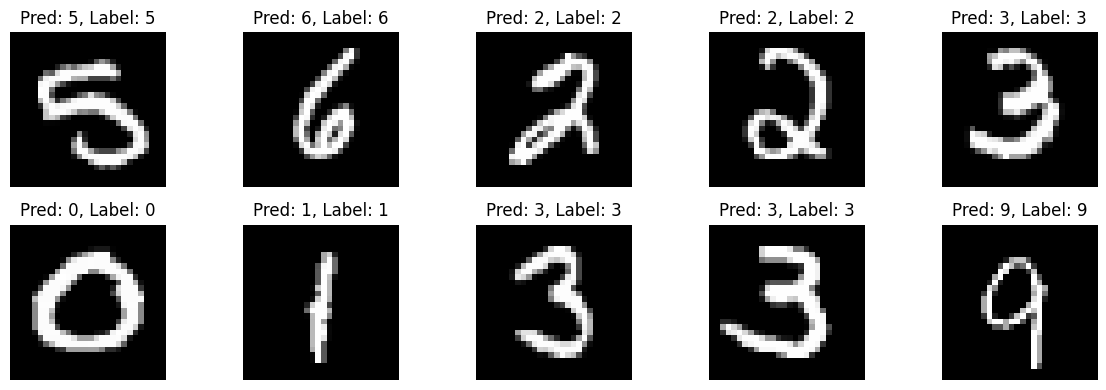

In [14]:
import matplotlib.pyplot as plt

model.eval()
images, labels = next(iter(val_loader))
images, labels = images.to(device), labels.to(device)
with torch.no_grad():
    outputs = model(images)
    preds = outputs.argmax(dim=1)

# move to cpu for plotting
images = images.cpu()
preds = preds.cpu()
labels = labels.cpu()

plt.figure(figsize=(12,4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"Pred: {preds[i].item()}, Label: {labels[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [16]:
!pip install onnxscript

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 94.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 18.9 MB/s eta 0:00:00


In [22]:
import torch

model.eval()
print(torch.__version__)

# (batch_size, num_channels, img_size, img_size) which is (1, 1, 28, 28) for MNIST
dummy_input = torch.randn(1, num_channels, img_size, img_size, dtype=torch.float32).to(device)

try:
    torch.onnx.export(
    model,
    dummy_input,
    "vit-mnist.onnx",
    input_names=["input"],
    output_names=["logits"],
    opset_version=18,
    do_constant_folding=True,
    dynamic_axes={"input": {0: "batch"}, "logits": {0: "batch"}},
    dynamo=False,
    external_data=False,
    )
    print("Model exported to vit-mnist.onnx successfully!")
except Exception as e:
    print(f"Error exporting model to ONNX: {e}")

2.9.0+cu126


/tmp/ipython-input-3197847208.py:10: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


Model exported to vit-mnist.onnx successfully!
